# Share and Update Building SLPK

This sample shares and updates one or more building SLPKs to ArcGIS Online. 

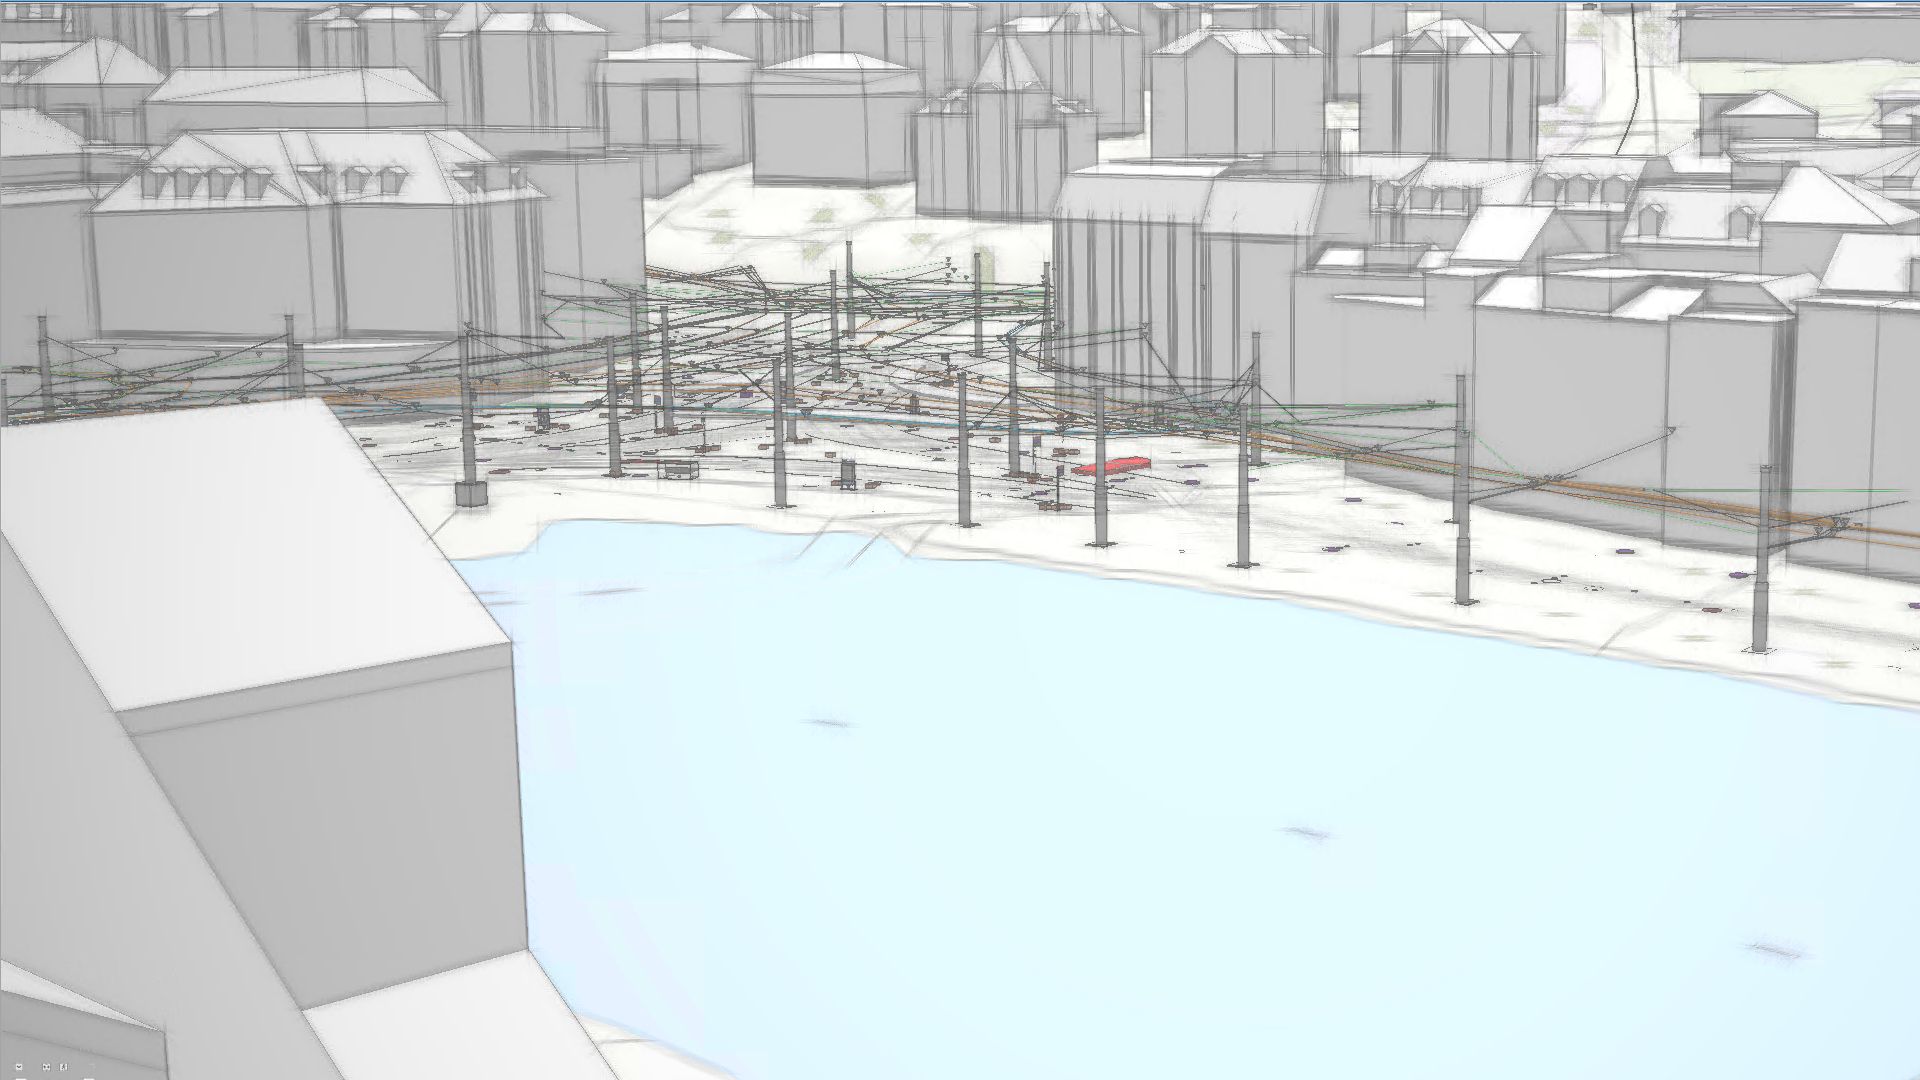

## Use case
Minimize production time with the most up-to-date project data required by the stakeholder.

## Requirements

- Ensure that the model(s) are already georeferenced.
- Sign in to an ArcGIS Online or ArcGIS Enterprise organization.



## How to use the sample
For an overview of the notebook, read this blog: [Automating BIM Data Publishing for ArcGIS: From Design to Digital Twin](https://www.esri.com/arcgis-blog/products/arcgis-online/aec/automating-bim-data-publishing-for-arcgis-from-design-to-digital-twin). Optionally, download the [sample data](https://www.arcgis.com/home/item.html?id=46dec36f758b45bba7fb195529faf17f) referenced in the blog. 


### Stage 1: Publish Building Scene Layer

#### Import Packages

In [ ]:
import arcpy
import os
import ast
import time

#### Define Variables

Change the variable paths and values to fit your working environment and project. 

To find the correct format for a desired transformation, you can consult this [list of supported geographic and vertical transformations](https://pro.arcgis.com/en/pro-app/latest/help/mapping/properties/pdf/geographic_transformations.pdf).

In [ ]:
# The BIM file or files that will be converted to geodatabase feature classes. 
# This could be Revit or IFC or both formats
bim_file_location = r'C:\TEMP\Automation_Blog\Automation_Sample\Revit\HUT_DA_60.rvt'

# The full path to the location of an existing ArcGIS Pro Project
project_path = r"C:\TEMP\Automation_Blog\Automation_Sample\GDB"

# The geodatabase where the output feature dataset will be created. 
# This must be an existing geodatabase in the provided project.
gdb_name = "DigitalModel_ProjectA_Del_60.gdb"

# The spatial reference of the output feature dataset. 
# The default will be the spatial reference defined
# by the projection file of the BIM File Workspace (IFC or Revit)
input_spatial_reference = "NAD_1983_2011_StatePlane_Maine_East_FIPS_1801_Ft_US"

# The building dataset name. 
# The name will be use also for the name of the
# building scene layer package and published layer. 
dataset_name = "Part_60"

# Desired coordinate system
ouput_coordinate_system =  "GCS_WGS_1984"

# Transformation used between the coordinate systems
intended_transformation = "WGS_1984_(ITRF08)_To_NAD_1983_2011"

#### Export the BIM file Workspace into a Feature Dataset

This step is optional if:
* your building/structure is represented by one single digital model or 
* you want to publish each digital model individually or
* you don’t require editing the geometry and/or attributes using Pro

Note: If a feature dataset of the provided `dataset_name` already exists in the target GDB, it will be deleted by this code.

In [ ]:
feature_dataset_path = os.path.join(project_path, gdb_name, dataset_name)

if arcpy.Exists(os.path.join(feature_dataset_path)):
    arcpy.Delete_management(feature_dataset_path)
    
arcpy.conversion.BIMFileToGeodatabase(
    in_bim_file_workspace = bim_file_location,
    out_gdb_path = os.path.join(project_path, gdb_name),
    out_dataset_name = dataset_name,
    spatial_reference = input_spatial_reference,
    include_floorplan = "EXCLUDE_FLOORPLAN"
)

Do not worry if some `WARNING 000117: Warning empty output generated.` messages are returned. It is common that not all possible layers will have content.

#### Create Temporary Building Layer from the Feature Dataset

This is an intermediate step that prepares data to be an input for the next step.

In [ ]:
temporary_layer = arcpy.management.MakeBuildingLayer(
    in_feature_dataset = feature_dataset_path,
    out_layer= f"{dataset_name}_Layer"
)

#### Create a Building Scene Layer Package

In [ ]:
slpk_path = os.path.join(project_path, f"{dataset_name}.slpk")
print(f"Creating output at {slpk_path}")

arcpy.management.CreateBuildingSceneLayerPackage(
    in_dataset = temporary_layer,
    out_slpk = slpk_path,
    out_coor_system = ouput_coordinate_system,
    transform_method = intended_transformation,
    texture_optimization = "DESKTOP",
    target_cloud_connection = None
)

#### Share the Package as a Building Scene Layer (hosted)

**NOTES :** 
* This tool will publish the package under the name provided by the user as `dataset_name`. It will fail if a layer of that name already exists in the organization.
* If running this notebook in ArcGIS Pro and the user is already logged into an organization through ArcGIS Pro, the tool will use these credentials and will not require a username/password.
* The organizational sharing and groups setting will depend on your organization.
* For best practices the Tags and Summary should be defined based on your project requirements.
* [Consulting a full list of the tool parameters is advised](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/share-package.htm)

In [ ]:
results = arcpy.management.SharePackage(
    in_package = slpk_path,
    username = "",
    password = "",
    summary = "BIM Project Example",
    tags = "3D, building scene layer",
    credits = "",
    public = "MYGROUPS",
    groups = None,
    organization = "MYORGANIZATION",
    publish_web_layer = "TRUE",
    portal_folder = "Delete"
)

In [ ]:
if results and results["out_results"] == "true":
    print(f"Successfully uploaded {slpk_path}\n")
    publish_results = ast.literal_eval(results["publish_results"])
    serviceItemId = publish_results["publishResult"]["serviceItemId"]
    print(f"Service Item ID: {serviceItemId}")
else:
    print(f"Error while attempting to upload {slpk_path}\n")

<br>**NOTE :** <br>
If proceeding to Part 2, make note of the Item ID returned by this step during your **original** publication. It will be the portal item targeted for updates as the project goes through the construction phases. 

## Stage 2: Replace the prior version of the Building Scene Layer

The prior version of the building scene layer will be replaced with the new version of the building scene layer.

**NOTE:** `The coordinate system should be the same between the original and the replacement building scene layer package.`

#### Find the item ID of the older phase of the project

Example `currentItemId = "09478f7efb6341b8bba51a9c3c984730"`. This is the Item ID of the **prior phase**

#### Define Variables

In [ ]:
# The web layer that will be replaced. 
currentItemId = "YOURCURRENTITEMID"

#### Replace Web Layer

In [ ]:
results = arcpy.server.ReplaceWebLayer(
    target_layer = currentItemId, 
    archive_layer_name = f"{dataset_name}_archive_{time.strftime('%Y%m%d')}", 
    update_layer = serviceItemId,
    replace_item_info = "REPLACE", 
    create_new_item = "TRUE"
)

print(f"Successfully replaced web layer at {results[0]}.")